In [75]:
import pandas as pd

In [76]:
df_raw = pd.read_csv('data2.csv')
df_raw.drop(columns=['Unnamed: 0'], inplace=True)
df = df_raw.copy()
print(df.shape)
df.head()

(42505, 7)


,Time,Resource,State,Activity,Material,Expected End Time,Target location
0,1.500824,S3,S3,created material,Material_3 instance N.0,NaN,NaN
1,1.500824,TR2,TP1,start state,Material_3 instance N.0,2.817491,S3
2,2.817491,TR2,TP1,end state,Material_3 instance N.0,2.817491,S3
3,2.817491,TR2,TP1,start state,Material_3 instance N.0,3.967491,R3
4,3.967491,TR2,TP1,end state,Material_3 instance N.0,3.967491,R3


In [77]:
import pm4py
import os
os.environ["PATH"] += os.pathsep + "C:/Program Files/Graphviz/bin"

In [78]:
df['DateTime'] = pd.to_datetime(df['Time'], unit='m')
df['Material_type'] = df['Material'].str[:10]
df['Combined_activity'] = df['State'] + ' ' + df['Activity']

In [79]:
df['Activity'].unique()

array(['created material', 'start state', 'end state', 'start interrupt',
       'end interrupt', 'finished material'], dtype=object)

In [80]:
len(df['Material'].unique())

2811

In [81]:
finished_material = df.loc[(df['Material'].notna()) & (df['Activity'] == "finished material")]['Material'].unique()
finished_material = pd.Series(finished_material, name="Material")
df_finished_material = pd.merge(df, finished_material)
df_finished_material.head()

,Time,Resource,State,Activity,Material,Expected End Time,Target location,DateTime,Material_type,Combined_activity
0,1.500824,S3,S3,created material,Material_3 instance N.0,NaN,NaN,1970-01-01 00:01:30.049447432,Material_3,S3 created material
1,1.500824,TR2,TP1,start state,Material_3 instance N.0,2.817491,S3,1970-01-01 00:01:30.049447432,Material_3,TP1 start state
2,2.817491,TR2,TP1,end state,Material_3 instance N.0,2.817491,S3,1970-01-01 00:02:49.049447432,Material_3,TP1 end state
3,2.817491,TR2,TP1,start state,Material_3 instance N.0,3.967491,R3,1970-01-01 00:02:49.049447432,Material_3,TP1 start state
4,3.967491,TR2,TP1,end state,Material_3 instance N.0,3.967491,R3,1970-01-01 00:03:58.049447432,Material_3,TP1 end state


In [82]:
df_for_pm4py = df_finished_material.loc[df_finished_material['Material'].notnull()]
df_for_pm4py = df_for_pm4py.rename(columns={'Material_type': 'Material:Material_type'})
df_for_pm4py = df_for_pm4py.loc[df_for_pm4py['Material:Material_type'] == 'Material_1']
df_for_pm4py = pm4py.format_dataframe(df_for_pm4py, case_id='Material', activity_key='Combined_activity', timestamp_key='DateTime')
log = pm4py.convert_to_event_log(df_for_pm4py)

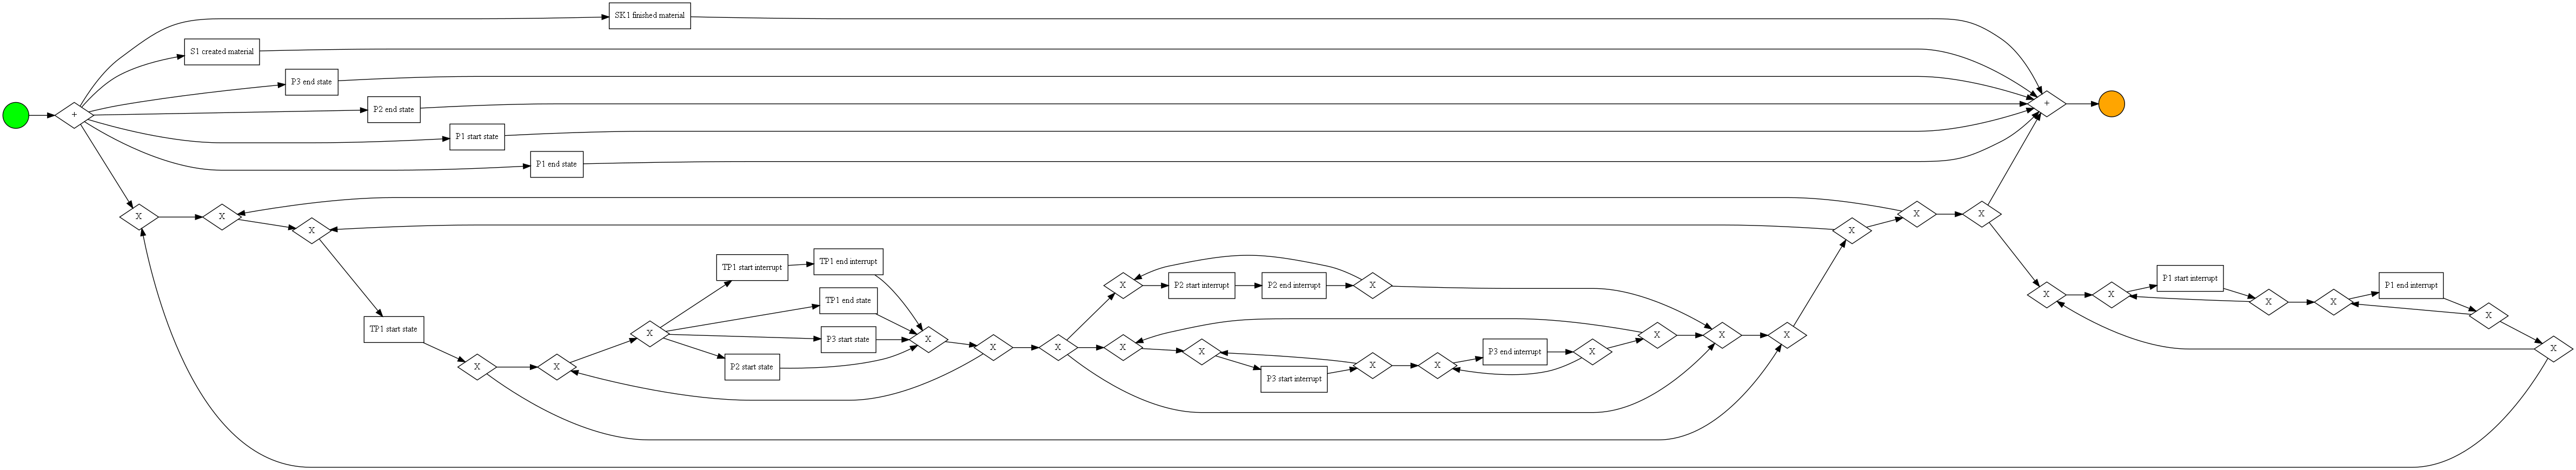

In [83]:
process_tree = pm4py.discover_process_tree_inductive(log)
bpmn_model = pm4py.convert_to_bpmn(process_tree)
pm4py.view_bpmn(bpmn_model, format = "png")

In [84]:
net, initial_marking, final_marking = pm4py.discover_petri_net_alpha(log)
# pm4py.view_petri_net(net, initial_marking, final_marking)


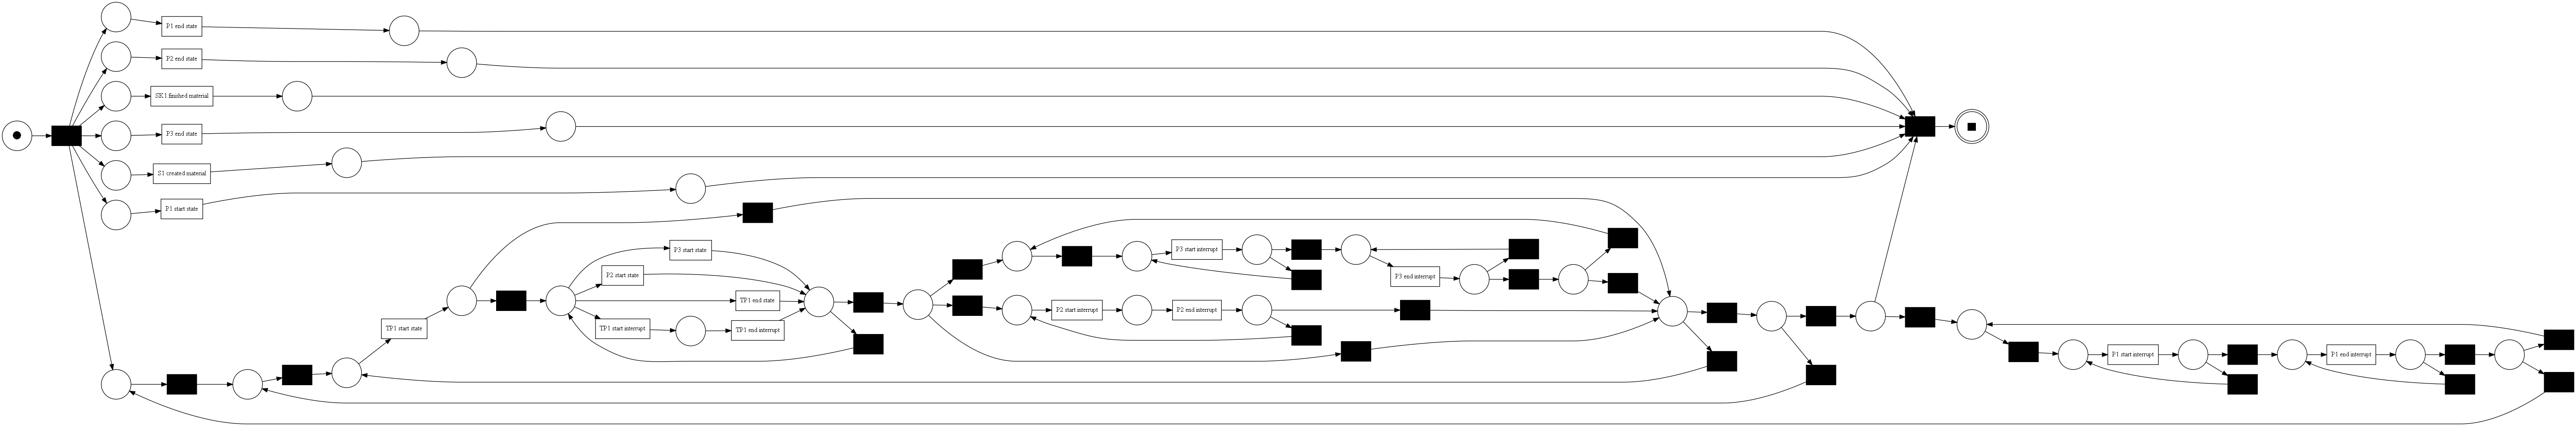

In [85]:
net, initial_marking, final_marking = pm4py.discover_petri_net_inductive(log)
pm4py.view_petri_net(net, initial_marking, final_marking)

In [86]:
from pm4py.visualization.petri_net import visualizer as pn_visualizer
parameters = {pn_visualizer.Variants.FREQUENCY.value.Parameters.FORMAT: "png"}
gviz = pn_visualizer.apply(net, initial_marking, final_marking, parameters=parameters, variant=pn_visualizer.Variants.FREQUENCY, log=log)
# pn_visualizer.save(gviz, "inductive_frequency.png")

replaying log with TBR, completed variants :: 100%|██████████| 357/357 [00:02<00:00, 139.45it/s]


In [87]:
# pm4py.discover_directly_follows_graph(log)

In [88]:
min = df_finished_material.groupby(by='Material')['Time'].min()
min.name = "Start_time"
max = df_finished_material.groupby(by='Material')['Time'].max()
max.name = "End_time"
tp = max - min
tp.name = "Throughput_time"

In [89]:
df_tp = pd.merge(df[['Material_type', 'Material']].drop_duplicates(), tp.to_frame().reset_index())
df_tp = pd.merge(df_tp, min.to_frame().reset_index())

In [90]:
import plotly.figure_factory as ff
import numpy as np

# Group data together
# hist_data = [x1, x2, x3, x4]

grouped = df_tp.groupby(by='Material_type')['Throughput_time'].apply(list)

values = grouped.values

group_labels = grouped.index

# Create distplot with custom bin_size
fig = ff.create_distplot(values, group_labels, bin_size=.2, show_curve=True, show_hist=False)
fig.show()

In [91]:
import plotly.express as px

fig = px.scatter(df_tp, x="Start_time", y="Throughput_time", color="Material_type")

fig.show()

In [92]:
df = df_raw.copy()
df['Material_type'] = df['Material'].str[:10]
df.loc[df['State'].str.contains('S'), 'State_type'] = 'Interface State'
df.loc[df['State'].str.contains('P'), 'State_type'] = 'Process State'
df.loc[df['State'].str.contains('Breakdown'), 'State_type'] = 'Breakdown State'

In [93]:
df_unique = df[['State_type', 'Activity']].drop_duplicates().sort_values(by=['State_type', 'Activity'])
df_unique

,State_type,Activity
42,Breakdown State,end state
13,Breakdown State,start state
0,Interface State,created material
66,Interface State,finished material
43,Process State,end interrupt
2,Process State,end state
12,Process State,start interrupt
1,Process State,start state


In [94]:
# TODO: add new states
df_unique = df[['State_type', 'Activity']].drop_duplicates().sort_values(by=['State_type', 'Activity'])
# df_unique['State_sorting_Index'] = [4, 3, 5, 6, 2, 1]
# df_unique['State_sorting_Index'] = [5, 4, 6, 1, 3, 2]
df_unique['State_sorting_Index'] = [2, 7, 1, 8, 3, 4, 6, 5]

df_unique.sort_values(by='State_sorting_Index', inplace=True)
df_unique

,State_type,Activity,State_sorting_Index
0,Interface State,created material,1
42,Breakdown State,end state,2
43,Process State,end interrupt,3
2,Process State,end state,4
1,Process State,start state,5
12,Process State,start interrupt,6
13,Breakdown State,start state,7
66,Interface State,finished material,8


In [95]:
df = pd.merge(df, df_unique)
df = df.sort_values(by=['Time', 'Resource', 'State_sorting_Index'])
df.head()

,Time,Resource,State,Activity,Material,Expected End Time,Target location,Material_type,State_type,State_sorting_Index
0,1.500824,S3,S3,created material,Material_3 instance N.0,NaN,NaN,Material_3,Interface State,1
2810,1.500824,TR2,TP1,start state,Material_3 instance N.0,2.817491,S3,Material_3,Process State,5
19629,2.817491,TR2,TP1,end state,Material_3 instance N.0,2.817491,S3,Material_3,Process State,4
2811,2.817491,TR2,TP1,start state,Material_3 instance N.0,3.967491,R3,Material_3,Process State,5
2812,3.967491,R3,P1,start state,Material_3 instance N.0,16.591047,NaN,Material_3,Process State,5


In [96]:
positive_condition = (df['State_type'] == 'Process State') & (df['Activity'] == 'start state')
negative_condition = (df['State_type'] == 'Process State') & (df['Activity'] == 'end state')

df['Increment'] = 0
df.loc[positive_condition, 'Increment'] = 1
df.loc[negative_condition, 'Increment'] = -1

df['Used_Capacity'] = df.groupby(by='Resource')['Increment'].cumsum()
df.head()

,Time,Resource,State,Activity,Material,Expected End Time,Target location,Material_type,State_type,State_sorting_Index,Increment,Used_Capacity
0,1.500824,S3,S3,created material,Material_3 instance N.0,NaN,NaN,Material_3,Interface State,1,0,0
2810,1.500824,TR2,TP1,start state,Material_3 instance N.0,2.817491,S3,Material_3,Process State,5,1,1
19629,2.817491,TR2,TP1,end state,Material_3 instance N.0,2.817491,S3,Material_3,Process State,4,-1,0
2811,2.817491,TR2,TP1,start state,Material_3 instance N.0,3.967491,R3,Material_3,Process State,5,1,1
2812,3.967491,R3,P1,start state,Material_3 instance N.0,16.591047,NaN,Material_3,Process State,5,1,1


In [97]:
df.groupby('Resource')['Used_Capacity'].max()

Resource
R1     2
R2     1
R3     2
R4     2
S1     0
S2     0
S3     0
SK1    0
SK2    0
SK3    0
TR1    1
TR2    1
Name: Used_Capacity, dtype: int64

In [98]:
import plotly.express as px

fig = px.scatter(df, x="Time", y="Used_Capacity", color="Resource")

# fig.show()

In [99]:
df['next_State_sorting_Index'] = df.groupby(by='Resource')['State_sorting_Index'].shift(-1)
df['next_Time'] = df.groupby('Resource')['Time'].shift(-1)
df.head()

,Time,Resource,State,Activity,Material,Expected End Time,Target location,Material_type,State_type,State_sorting_Index,Increment,Used_Capacity,next_State_sorting_Index,next_Time
0,1.500824,S3,S3,created material,Material_3 instance N.0,NaN,NaN,Material_3,Interface State,1,0,0,1.0,65.433357
2810,1.500824,TR2,TP1,start state,Material_3 instance N.0,2.817491,S3,Material_3,Process State,5,1,1,4.0,2.817491
19629,2.817491,TR2,TP1,end state,Material_3 instance N.0,2.817491,S3,Material_3,Process State,4,-1,0,5.0,2.817491
2811,2.817491,TR2,TP1,start state,Material_3 instance N.0,3.967491,R3,Material_3,Process State,5,1,1,4.0,3.967491
2812,3.967491,R3,P1,start state,Material_3 instance N.0,16.591047,NaN,Material_3,Process State,5,1,1,4.0,16.591047


In [100]:
df_unique

,State_type,Activity,State_sorting_Index
0,Interface State,created material,1
42,Breakdown State,end state,2
43,Process State,end interrupt,3
2,Process State,end state,4
1,Process State,start state,5
12,Process State,start interrupt,6
13,Breakdown State,start state,7
66,Interface State,finished material,8


In [101]:
STANDBY_CONDITION = (df['State_sorting_Index'] == 2) | ((df['State_sorting_Index'] == 4) & (df['Used_Capacity'] == 0))
PRODUCTIVE_CONDITION = (df['State_sorting_Index'] == 5) | (df['State_sorting_Index'] == 3) | ((df['State_sorting_Index'] == 3) & df['Used_Capacity'] != 0)
DOWN_CONDITION = (df['State_sorting_Index'] == 6) | (df['State_sorting_Index'] == 7)

df['time_increment'] = df['next_Time'] - df['Time']

df.loc[STANDBY_CONDITION, 'Time_type'] = 'SB'
df.loc[PRODUCTIVE_CONDITION, 'Time_type'] = 'PR'
df.loc[DOWN_CONDITION, 'Time_type'] = 'UD'

In [102]:
df.head()

,Time,Resource,State,Activity,Material,Expected End Time,Target location,Material_type,State_type,State_sorting_Index,Increment,Used_Capacity,next_State_sorting_Index,next_Time,time_increment,Time_type
0,1.500824,S3,S3,created material,Material_3 instance N.0,NaN,NaN,Material_3,Interface State,1,0,0,1.0,65.433357,63.932533,NaN
2810,1.500824,TR2,TP1,start state,Material_3 instance N.0,2.817491,S3,Material_3,Process State,5,1,1,4.0,2.817491,1.316667,PR
19629,2.817491,TR2,TP1,end state,Material_3 instance N.0,2.817491,S3,Material_3,Process State,4,-1,0,5.0,2.817491,0.000000,SB
2811,2.817491,TR2,TP1,start state,Material_3 instance N.0,3.967491,R3,Material_3,Process State,5,1,1,4.0,3.967491,1.150000,PR
2812,3.967491,R3,P1,start state,Material_3 instance N.0,16.591047,NaN,Material_3,Process State,5,1,1,4.0,16.591047,12.623556,PR


In [103]:
# df.loc[df['Resource'] == 'R3', ['Time', 'State', 'Activity', 'State_sorting_Index', 'Used_Capacity', 'time_increment', 'Time_type']].head()

In [104]:
df_time_per_state = df.groupby(['Resource', 'Time_type'])['time_increment'].sum()
df_time_per_state = df_time_per_state.to_frame().reset_index()
# df_time_per_state

In [105]:
df_resource_time = df_time_per_state.groupby(by='Resource').sum().reset_index()
df_resource_time.rename(columns={'time_increment': 'resource_time'}, inplace=True)
df_time_per_state = pd.merge(df_time_per_state, df_resource_time)
# time_ratio = df_time_ratio / df_time_ratio_resource_time
df_time_per_state['percentage'] = df_time_per_state['time_increment'] / df_time_per_state['resource_time']

In [106]:
import plotly.express as px

fig = px.bar(df_time_per_state, x="Resource", y="time_increment", color="Time_type", color_discrete_map={'PR': 'green', 'SB': 'yellow', 'UD': 'red' })
fig.show()

In [109]:
CREATED_CONDITION = df['Activity'] == "created material"
FINISHED_CONDITION = df['Activity'] == "finished material"

df['WIP_Increment'] = 0
df.loc[CREATED_CONDITION, 'WIP_Increment'] = 1
df.loc[FINISHED_CONDITION, 'WIP_Increment'] = -1

df['WIP'] = df['WIP_Increment'].cumsum()

In [110]:
import plotly.express as px

fig = px.scatter(df, x="Time", y="WIP")

fig.show()

In [ ]:
def troughput_per_time_increment(df, time_increment):
    pass